In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.linear_model import LinearRegression, ElasticNet
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import xgboost as xgb
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


In [2]:
# Load data
df = pd.read_csv(r"e:/Nieuw dataset/Joined trends/joined_trend_sales_All1.csv")
df["Periode"] = pd.to_datetime(df["Periode"], format="%Y/%m")
df = df.sort_values("Periode").reset_index(drop=True)

# Create lag features and date parts
for lag in range(1, 7):
    df[f"TVV_Lag{lag}"] = df["Totaal_verkochte_wegvoertuigen"].shift(lag)
df_lagged = df.dropna().reset_index(drop=True)
df_lagged['year'] = df_lagged['Periode'].dt.year
df_lagged['month'] = df_lagged['Periode'].dt.month
df_lagged['quarter'] = df_lagged['Periode'].dt.quarter
cols = [col for col in df_lagged.columns if col != 'Totaal_verkochte_wegvoertuigen'] + ['Totaal_verkochte_wegvoertuigen']
df_lagged = df_lagged[cols]

In [3]:
# Define lag and time features to add to all subsets
lag_time_features = ['TVV_Lag1', 'TVV_Lag2', 'TVV_Lag3', 'TVV_Lag4', 'TVV_Lag5', 'TVV_Lag6', 'year', 'month', 'quarter']

# Redefine feature sets with those always included
feature_sets = {
    'Lag Only': lag_time_features,
    'Keywords + Lag': lag_time_features + ['thuis opladen', 'elektrische auto', 'hybride elektrisch'],
    'Bijtelling + Lag': lag_time_features + ['Bijtelling (%)'],
    'Confidence + Lag': lag_time_features + ['Consumentenvertrouwen', 'Economisch klimaat', 'Koopbereidheid', 'Grote aankopen'],
    'Fuel + Lag': lag_time_features + [
        'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
        'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
        'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
    ]
}

# Add full feature set: everything except target and 'Periode'
all_features = [
    'thuis opladen', 'elektrische auto', 'hybride elektrisch',
    'Bijtelling (%)', 'Consumentenvertrouwen', 'Economisch klimaat',
    'Koopbereidheid', 'Grote aankopen',
    'BenzineEuro95_1_first', 'BenzineEuro95_1_last', 'BenzineEuro95_1_min',
    'BenzineEuro95_1_max', 'BenzineEuro95_1_mean',
    'Diesel_2_first', 'Diesel_2_last', 'Diesel_2_min', 'Diesel_2_max', 'Diesel_2_mean'
] + lag_time_features

feature_sets['All Features'] = all_features

 Aangepaste versie mét rolling test forecast

In [ ]:

# import numpy as np
# from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

# def strict_expanding_window_validation(
#     df, features, target_col, model_fn,
#     forecast_horizon=3
# ):
#     n = len(df)
#     test_start = int(n * 0.85)  # laatste 15% = test
#     val_start = int(n * 0.7)    # 70% = start validatie

#     X = df[features].values
#     y = df[target_col].values

#     # Splits
#     X_trainval = X[:test_start]
#     y_trainval = y[:test_start]
#     X_test = X[test_start:]
#     y_test = y[test_start:]
#     test_dates = df.iloc[test_start:]['Periode'].values

#     # Expanding window over validatieperiode (binnen trainval)
#     val_preds, val_actuals, val_dates = [], [], []
#     for i in range(val_start, len(X_trainval) - forecast_horizon + 1):
#         X_train = X_trainval[:i]
#         y_train = y_trainval[:i]
#         X_val = X_trainval[i:i+forecast_horizon]
#         y_val = y_trainval[i:i+forecast_horizon]
#         if len(X_val) == 0:
#             break
#         model = model_fn()
#         model.fit(X_train, y_train)
#         preds = model.predict(X_val)
#         val_preds.extend(preds)
#         val_actuals.extend(y_val)
#         val_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

#     # Final model: train op alles behalve test, test op testset
#     model = model_fn()
#     model.fit(X_trainval, y_trainval)
#     test_preds = model.predict(X_test)

#     # Scores
#     val_mae = mean_absolute_error(val_actuals, val_preds)
#     val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
#     val_r2 = r2_score(val_actuals, val_preds)
#     val_mape = mean_absolute_percentage_error(val_actuals, val_preds)

#     test_mae = mean_absolute_error(y_test, test_preds)
#     test_rmse = np.sqrt(mean_squared_error(y_test, test_preds))
#     test_r2 = r2_score(y_test, test_preds)
#     test_mape = mean_absolute_percentage_error(y_test, test_preds)

#     return {
#         "val_mae": val_mae,
#         "val_rmse": val_rmse,
#         "val_r2": val_r2,
#         "val_mape": val_mape,
#         "val_preds": np.array(val_preds),
#         "val_actuals": np.array(val_actuals),
#         "val_dates": np.array(val_dates),
#         "test_mae": test_mae,
#         "test_rmse": test_rmse,
#         "test_r2": test_r2,
#         "test_mape": test_mape,
#         "test_preds": test_preds,
#         "test_actuals": y_test,
#         "test_dates": test_dates
#     }

In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

def strict_expanding_window_validation(
    df, features, target_col, model_fn,
    forecast_horizon=3
):
    n = len(df)
    test_start = int(n * 0.85)
    val_start = int(n * 0.75)

    X = df[features].values
    y = df[target_col].values

    # === VALIDATIE (expanding window binnen trainval) ===
    val_preds, val_actuals, val_dates = [], [], []
    for i in range(val_start, test_start - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_val = X[i:i+forecast_horizon]
        y_val = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        val_preds.extend(preds)
        val_actuals.extend(y_val)
        val_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    # === TEST (rolling window vanaf test_start) ===
    test_preds, test_actuals, test_dates = [], [], []
    for i in range(test_start, n - forecast_horizon + 1):
        X_train = X[:i]
        y_train = y[:i]
        X_test = X[i:i+forecast_horizon]
        y_test = y[i:i+forecast_horizon]

        model = model_fn()
        model.fit(X_train, y_train)
        preds = model.predict(X_test)

        test_preds.extend(preds)
        test_actuals.extend(y_test)
        test_dates.extend(df.iloc[i:i+forecast_horizon]['Periode'].values)

    # === Scores ===
    val_mae = mean_absolute_error(val_actuals, val_preds)
    val_rmse = np.sqrt(mean_squared_error(val_actuals, val_preds))
    val_r2 = r2_score(val_actuals, val_preds)
    val_mape = mean_absolute_percentage_error(val_actuals, val_preds)

    test_mae = mean_absolute_error(test_actuals, test_preds)
    test_rmse = np.sqrt(mean_squared_error(test_actuals, test_preds))
    test_r2 = r2_score(test_actuals, test_preds)
    test_mape = mean_absolute_percentage_error(test_actuals, test_preds)

    return {
        "val_mae": val_mae,
        "val_rmse": val_rmse,
        "val_r2": val_r2,
        "val_mape": val_mape,
        "val_preds": np.array(val_preds),
        "val_actuals": np.array(val_actuals),
        "val_dates": np.array(val_dates),
        "test_mae": test_mae,
        "test_rmse": test_rmse,
        "test_r2": test_r2,
        "test_mape": test_mape,
        "test_preds": np.array(test_preds),
        "test_actuals": np.array(test_actuals),
        "test_dates": np.array(test_dates)
    }


### Explanation of the Data Split and Expanding Window Validation

This function implements a strict time series split with expanding window validation and a rolling test forecast. The data is divided as follows:

- **Training set:** The first 75% of the data (from the start up to 75% of the timeline).
- **Validation set:** The next 10% of the data (from 75% to 85% of the timeline). Validation is performed using an expanding window: for each step, the model is trained on all data up to that point and validated on the next `forecast_horizon` periods.
- **Test set:** The final 15% of the data (from 85% to 100% of the timeline). Testing is also done with a rolling window: for each step, the model is trained on all data up to that point and tested on the next `forecast_horizon` periods.

**Key points:**
- At every step, only past data is used to predict future values, preventing lookahead bias and data leakage.
- The validation and test predictions are made in a way that simulates real-world forecasting, where only information up to the prediction date is available.
- This approach is robust for time series forecasting and ensures that model evaluation is realistic and fair.


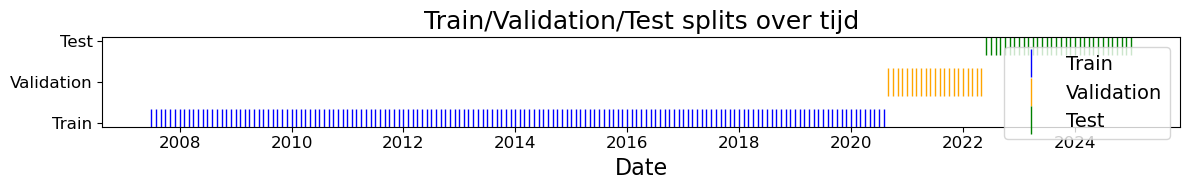

Train months: 2007-07 -> 2020-08 (158 maanden)
Validation months: 2020-09 -> 2022-05 (21 maanden)
Test months: 2022-06 -> 2025-01 (32 maanden)


In [27]:
import matplotlib.pyplot as plt

# Bepaal de indexen voor splits (zelfde logica als in je validatiefunctie)
n = len(df_lagged)
train_end = int(n * 0.75)
val_end = int(n * 0.85)
test_end = n

train_dates = df_lagged['Periode'].iloc[:train_end]
val_dates = df_lagged['Periode'].iloc[train_end:val_end]
test_dates = df_lagged['Periode'].iloc[val_end:test_end]

plt.figure(figsize=(12, 2))
plt.plot(train_dates, [1]*len(train_dates), '|', color='blue', markersize=20, label='Train')
plt.plot(val_dates, [2]*len(val_dates), '|', color='orange', markersize=20, label='Validation')
plt.plot(test_dates, [3]*len(test_dates), '|', color='green', markersize=20, label='Test')

plt.yticks([1, 2, 3], ['Train', 'Validation', 'Test'])
plt.xlabel('Date')
plt.title('Train/Validation/Test splits over tijd')
plt.legend()
plt.tight_layout()
plt.show()
print("Train months:", train_dates.min().strftime("%Y-%m"), "->", train_dates.max().strftime("%Y-%m"), f"({len(train_dates)} maanden)")
print("Validation months:", val_dates.min().strftime("%Y-%m"), "->", val_dates.max().strftime("%Y-%m"), f"({len(val_dates)} maanden)")
print("Test months:", test_dates.min().strftime("%Y-%m"), "->", test_dates.max().strftime("%Y-%m"), f"({len(test_dates)} maanden)")


In [20]:
print("Train dates:")
print(df_lagged['Periode'].iloc[:train_end].min(), "->", df_lagged['Periode'].iloc[:train_end].max())
print("Aantal train:", train_end, f"({train_end/len(df_lagged)*100:.1f}%)")

print("\nValidation dates:")
print(df_lagged['Periode'].iloc[train_end:val_end].min(), "->", df_lagged['Periode'].iloc[train_end:val_end].max())
print("Aantal validatie:", val_end - train_end, f"({(val_end-train_end)/len(df_lagged)*100:.1f}%)")

print("\nTest dates:")
print(df_lagged['Periode'].iloc[val_end:test_end].min(), "->", df_lagged['Periode'].iloc[val_end:test_end].max())
print("Aantal test:", test_end - val_end, f"({(test_end-val_end)/len(df_lagged)*100:.1f}%)")

Train dates:
2007-07-01 00:00:00 -> 2020-08-01 00:00:00
Aantal train: 158 (74.9%)

Validation dates:
2020-09-01 00:00:00 -> 2022-05-01 00:00:00
Aantal validatie: 21 (10.0%)

Test dates:
2022-06-01 00:00:00 -> 2025-01-01 00:00:00
Aantal test: 32 (15.2%)


#### Nulmodel

Mask sum: 21 (should be >0)
Random Walk (Lag Only) nulmodel MAPE: 0.3480


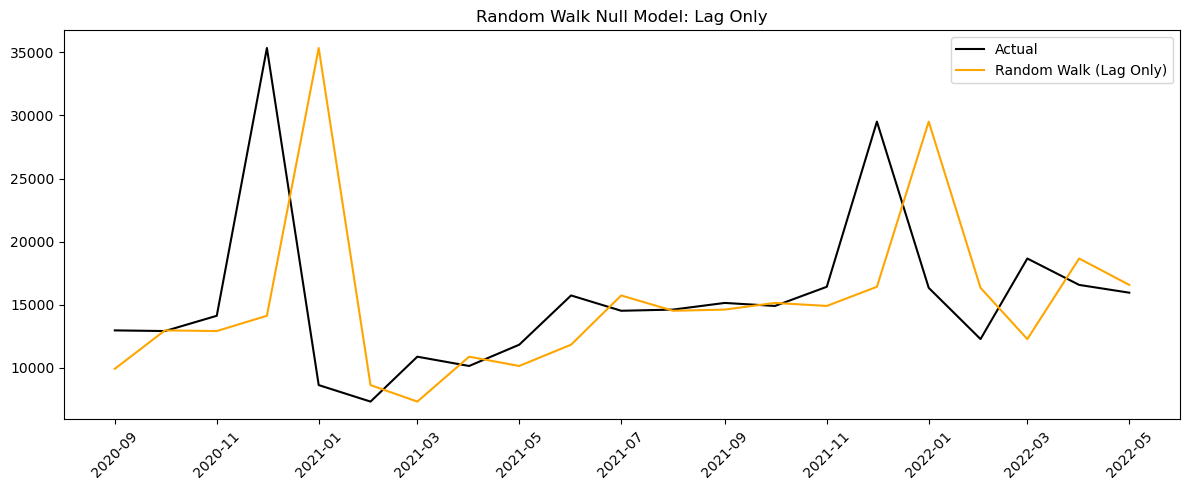

In [22]:

from sklearn.metrics import mean_absolute_percentage_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Haal de validatiedatums op uit je model-validatie (gebruik dezelfde split!)
val_dates = strict_expanding_window_validation(
    df_lagged, feature_sets['Lag Only'], 'Totaal_verkochte_wegvoertuigen',
    lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, 
                             learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
    forecast_horizon=3
)['val_dates']
val_dates = pd.to_datetime(val_dates)

results = {}
for label, features in feature_sets.items():
    if label != 'Lag Only':
        continue

    val_preds = df_lagged['TVV_Lag1'].values
    val_actuals = df_lagged['Totaal_verkochte_wegvoertuigen'].values
    validation_dates = pd.to_datetime(df_lagged['Periode'].values)

    # Filter alleen de datums die in de validatieset zitten
    mask = validation_dates.isin(val_dates)
    print(f"Mask sum: {mask.sum()} (should be >0)")
    val_preds = val_preds[mask]
    val_actuals = val_actuals[mask]
    validation_dates = validation_dates[mask]

    results[label] = pd.DataFrame({
        'date': validation_dates,
        'actual': val_actuals,
        'pred': val_preds
    }).drop_duplicates(subset='date', keep='first')

    # MAPE voor Random Walk (Lag Only) nulmodel op validatieset
    mape_lag = mean_absolute_percentage_error(val_actuals, val_preds)
    print(f"Random Walk (Lag Only) nulmodel MAPE: {mape_lag:.4f}")

df_lag = results['Lag Only'][['date', 'actual', 'pred']].rename(columns={'pred': 'pred_lag'})

plt.figure(figsize=(12, 5))
plt.plot(df_lag['date'], df_lag['actual'], label='Actual', color='black')
plt.plot(df_lag['date'], df_lag['pred_lag'], label='Random Walk (Lag Only)', color='orange')
plt.title('Random Walk Null Model: Lag Only')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Baseline

#### XGBoost

XGBoost (Lag Only): MAPE=0.2111, MAE=3138.81, RMSE=4217.81, R²=0.578
XGBoost (All Features): MAPE=0.3174, MAE=4282.95, RMSE=6666.06, R²=-0.054


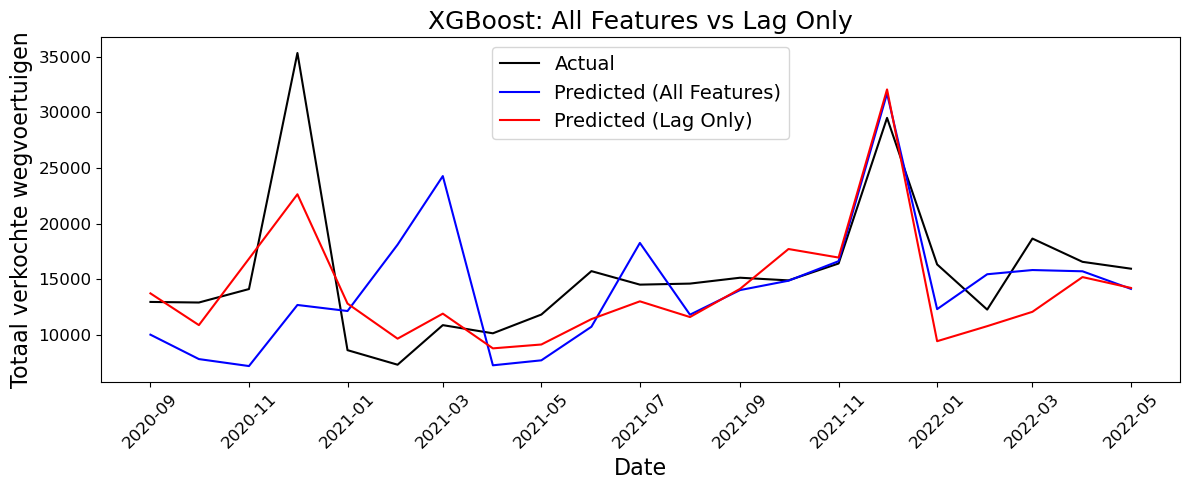

In [23]:


results = {}
for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue  # Sla andere feature sets over

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100,
                                 learning_rate=0.1, max_depth=3, random_state=42, eval_metric="rmse"),
        forecast_horizon=3
    )
    print(f"XGBoost ({label}): MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

    # Sla resultaten op in dictionary
    results[label] = {
        'date': pd.to_datetime(res['val_dates']),
        'actual': res['val_actuals'],
        'pred': res['val_preds']
    }

# Maak DataFrames van de resultaten
df_all = pd.DataFrame(results['All Features']).drop_duplicates(subset='date', keep='first')
df_lag = pd.DataFrame(results['Lag Only']).drop_duplicates(subset='date', keep='first')

# Merge op datum
df_merged = pd.merge(
    df_all[['date', 'actual', 'pred']].rename(columns={'pred': 'pred_all'}),
    df_lag[['date', 'pred']].rename(columns={'pred': 'pred_lag'}),
    on='date',
    how='inner'
)

plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
plt.figure(figsize=(12, 5))
plt.plot(df_merged['date'], df_merged['actual'], label='Actual', color='black')
plt.plot(df_merged['date'], df_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_merged['date'], df_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('XGBoost: All Features vs Lag Only')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




#### Arimax

ARIMAX (Lag Only): MAPE=0.5708, MAE=7854.58, RMSE=11046.13, R²=-1.895
ARIMAX (All Features): MAPE=0.5690, MAE=7596.93, RMSE=12042.74, R²=-2.441


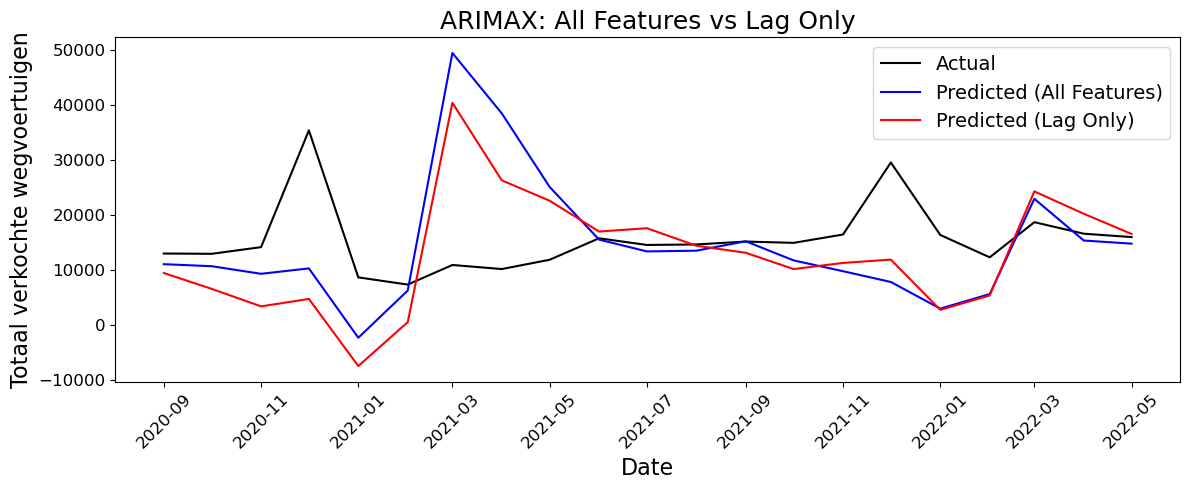

In [26]:
from sklearn.preprocessing import StandardScaler

# ARIMAX wrapper met standaardisatie
class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        model = SARIMAX(y, exog=X_scaled, order=self.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self
        
    def predict(self, X):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)

arimax_results = {}

# Voer ARIMAX uit voor beide feature sets
for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: ARIMAXWrapper(order=(1, 1, 1)),
        forecast_horizon=3
    )

    print(f"ARIMAX ({label}): MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

    # Sla resultaten op
    arimax_results[label] = {
        'date': pd.to_datetime(res['val_dates']),
        'actual': res['val_actuals'],
        'pred': res['val_preds']
    }

# Maak DataFrames en merge net als bij XGBoost
df_arimax_all = pd.DataFrame(arimax_results['All Features']).drop_duplicates(subset='date', keep='first')
df_arimax_lag = pd.DataFrame(arimax_results['Lag Only']).drop_duplicates(subset='date', keep='first')

df_arimax_merged = pd.merge(
    df_arimax_all[['date', 'actual', 'pred']].rename(columns={'pred': 'pred_all'}),
    df_arimax_lag[['date', 'pred']].rename(columns={'pred': 'pred_lag'}),
    on='date',
    how='inner'
)

# Plot vergelijkende ARIMAX-grafiek
plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
plt.figure(figsize=(12, 5))
plt.plot(df_arimax_merged['date'], df_arimax_merged['actual'], label='Actual', color='black')
plt.plot(df_arimax_merged['date'], df_arimax_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_arimax_merged['date'], df_arimax_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('ARIMAX: All Features vs Lag Only')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### Fine tune XGBoost

> Iteratie 1: max_depth

In [ ]:

for max_depth in [1, 2, 3, 5, 7, 9]:
    print(f"\nTesting max_depth={max_depth}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=max_depth,
            subsample=1.0,
            min_child_weight=1,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        forecast_horizon=3
    )
    print(f"max_depth={max_depth}: MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Testing max_depth=1
max_depth=1: MAPE=0.3456, MAE=5258.12, RMSE=7763.27, R²=-0.430

Testing max_depth=2
max_depth=2: MAPE=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing max_depth=3
max_depth=3: MAPE=0.3174, MAE=4282.95, RMSE=6666.06, R²=-0.054

Testing max_depth=5
max_depth=5: MAPE=0.3479, MAE=4816.43, RMSE=6888.63, R²=-0.126

Testing max_depth=7
max_depth=7: MAPE=0.3554, MAE=4934.12, RMSE=6944.89, R²=-0.144

Testing max_depth=9
max_depth=9: MAPE=0.3556, MAE=4940.65, RMSE=6955.93, R²=-0.148


max debt van 3 naar 2

> Iteratie 2: min_child_weight

In [38]:

# Baseline MAPE
baseline_mape = 0.2380 

print(f"Baseline MAPE: {baseline_mape:.4f}")

for min_child_weight in [1, 3, 5, 7, 10]:
    print(f"\nTesting min_child_weight={min_child_weight}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=2,
            min_child_weight=min_child_weight,
            subsample=1.0,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        
        forecast_horizon=3
    )
    print(f"min_child_weightAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

Baseline MAPE: 0.2380

Testing min_child_weight=1
min_child_weightAPE=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing min_child_weight=3
min_child_weightAPE=0.3184, MAE=4975.05, RMSE=6760.89, R²=-0.085

Testing min_child_weight=5
min_child_weightAPE=0.2971, MAE=4755.58, RMSE=6821.62, R²=-0.104

Testing min_child_weight=7
min_child_weightAPE=0.2839, MAE=4521.58, RMSE=6634.03, R²=-0.044

Testing min_child_weight=10
min_child_weightAPE=0.2403, MAE=3906.89, RMSE=6273.87, R²=0.066


baseline van 1 werkt het beste/ toont zelfde resultaat 

> iteratie 3: subsample

In [39]:
# Baseline MAPE
baseline_mape = 2380

print(f"Baseline MAPE: {baseline_mape:.4f}")

for subsample in [1.0, 0.8, 0.6, 0.5]:
    print(f"\nTesting subsample={subsample}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=2,
            min_child_weight=1,
            subsample=subsample,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        
        forecast_horizon=3
    )
    print(f"subsample={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Baseline MAPE: 2380.0000

Testing subsample=1.0
subsample=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing subsample=0.8
subsample=0.2689, MAE=3967.46, RMSE=6296.40, R²=0.059

Testing subsample=0.6
subsample=0.3223, MAE=4692.81, RMSE=6681.07, R²=-0.059

Testing subsample=0.5
subsample=0.3563, MAE=5250.28, RMSE=7173.75, R²=-0.221


subsample default 1 werkt het best 

> iteratie 4': colsample_bytree

In [40]:
baseline_mape = 0.2380
print(f"Baseline MAPE: {baseline_mape:.4f}")
for colsample_bytree in [1.0, 0.8, 0.6, 0.5]:
    print(f"\nTesting colsample_bytree={colsample_bytree}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=0.1,
            max_depth=2,
            min_child_weight=1,
            subsample=1,
            colsample_bytree=colsample_bytree,
            random_state=42,
            eval_metric="rmse"
        ),
        forecast_horizon=3
        
    )
    print(f"colsample_bytree={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Baseline MAPE: 0.2380

Testing colsample_bytree=1.0
colsample_bytree=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing colsample_bytree=0.8
colsample_bytree=0.2642, MAE=4070.50, RMSE=6237.53, R²=0.077

Testing colsample_bytree=0.6
colsample_bytree=0.2708, MAE=4122.53, RMSE=6308.69, R²=0.056

Testing colsample_bytree=0.5
colsample_bytree=0.2649, MAE=4126.16, RMSE=6338.32, R²=0.047


Colsample baseline is best = 0.2403

> iteratie 5: learning_rate

In [41]:


print(f"Baseline MAPE: {baseline_mape:.4f}")

for learning_rate in [0.3, 0.1, 0.05, 0.01]:
    print(f"\nTesting learning_rate={learning_rate}")
    res = strict_expanding_window_validation(
        df_lagged, feature_sets['All Features'], 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            learning_rate=learning_rate,
            max_depth=2,
            min_child_weight=1,
            subsample=1,
            colsample_bytree=1.0,
            random_state=42,
            eval_metric="rmse"
        ),
        
        forecast_horizon=3
    )
    print(f"learning_rate={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")


Baseline MAPE: 0.2380

Testing learning_rate=0.3
learning_rate=0.2279, MAE=3703.00, RMSE=6042.67, R²=0.134

Testing learning_rate=0.1
learning_rate=0.2380, MAE=3760.07, RMSE=6006.65, R²=0.144

Testing learning_rate=0.05
learning_rate=0.2403, MAE=3846.57, RMSE=6222.34, R²=0.081

Testing learning_rate=0.01
learning_rate=0.4559, MAE=7736.35, RMSE=9559.57, R²=-1.168


Andere tuningopties staan hieronder vermeld, maar zijn niet gebruikt omdat ze overfitting kunnen veroorzaken. Bovendien zijn de bovenste vijf iteraties het belangrijkst voor tuning

> iteratie 6: n_estimators

> iteratie 7: gamma

> iteratie 8: reg_alpha

> iteratie 9: reg_lambda

> iteratie 10: tree_method

### Opslaan beste model

In [42]:
best_model = xgb.XGBRegressor(
    objective='reg:squarederror',
     max_depth = 2,
    min_child_weight = 1,
    subsample = 1,
    colsample_bytree = 1.0,
    learning_rate = 0.3,
    n_estimators = 100,
)

# X en y definiëren (train op volledige dataset)
X = df_lagged[feature_sets['All Features']]
y = df_lagged['Totaal_verkochte_wegvoertuigen']

# Fit model
best_model.fit(X, y)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.3, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=1, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [43]:
best_model.save_model("best_xgboost_model.json")


### Grid search

In [45]:
param_grid = {
    'max_depth': [3, 5, 7],              # Prima. 3–7 is een veilige range. >7 = risico op overfitting.
    'min_child_weight': [1, 3, 5],       # Goed. Hoe hoger, hoe meer regularisatie (minder splits).
    'subsample': [1.0, 0.8, 0.6],        # Goed. <1.0 = dropout van observaties = helpt tegen overfitten.
    'colsample_bytree': [1.0, 0.8, 0.6], # Goed. <1.0 = feature dropout = helpt tegen overfitten.
}


In [47]:



import itertools

# Alle combinaties
keys, values = zip(*param_grid.items())
combinations = [dict(zip(keys, v)) for v in itertools.product(*values)]

best_mape = float('inf')
best_params = None

for i, params in enumerate(combinations):
    print(f"\nTesting combination {i+1}/{len(combinations)}: {params}")

    res = strict_expanding_window_validation(
        df_lagged,
        feature_sets['All Features'],
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            eval_metric='rmse',
            random_state=42,
            tree_method='exact',
            **params
        ),
        
        forecast_horizon=3
    )

    print(f"MAPE={res['val_mape']:.4f}, MAE={res['val_mae']:.2f}, RMSE={res['val_rmse']:.2f}, R²={res['val_r2']:.3f}")

    if res['val_mape'] < best_mape:
        best_mape = res['val_mape']
        best_params = params

    


Testing combination 1/81: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0}
MAPE=0.2398, MAE=3547.24, RMSE=5632.97, R²=0.247

Testing combination 2/81: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.8}
MAPE=0.2619, MAE=3734.70, RMSE=5869.13, R²=0.183

Testing combination 3/81: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 0.6}
MAPE=0.2876, MAE=4244.61, RMSE=6453.72, R²=0.012

Testing combination 4/81: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 1.0}
MAPE=0.3542, MAE=4689.44, RMSE=7372.04, R²=-0.290

Testing combination 5/81: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.8}
MAPE=0.3773, MAE=5232.54, RMSE=7863.44, R²=-0.467

Testing combination 6/81: {'max_depth': 3, 'min_child_weight': 1, 'subsample': 0.8, 'colsample_bytree': 0.6}
MAPE=0.3505, MAE=5023.12, RMSE=7905.76, R²=-0.483

Testing combination 7/81: {'max_depth': 3,

In [48]:
print("\n Beste parameters volgens grid search:")
print(best_params)
print(f"MAPE: {best_mape:.4f}")




 Beste parameters volgens grid search:
{'max_depth': 3, 'min_child_weight': 1, 'subsample': 1.0, 'colsample_bytree': 1.0}
MAPE: 0.2398


## Testset


The test set was predicted using the entire training and validation period (85% of the data). Despite this, the model fails to capture the upward trend in recent years, suggesting limitations in feature design or model expressiveness rather than in the data split.

### Grid op testset


XGBoost (All Features) - TESTSET (Grid Search Parameters):
MAPE = 0.1371
MAE  = 3471.94
RMSE = 4689.72
R²   = 0.253


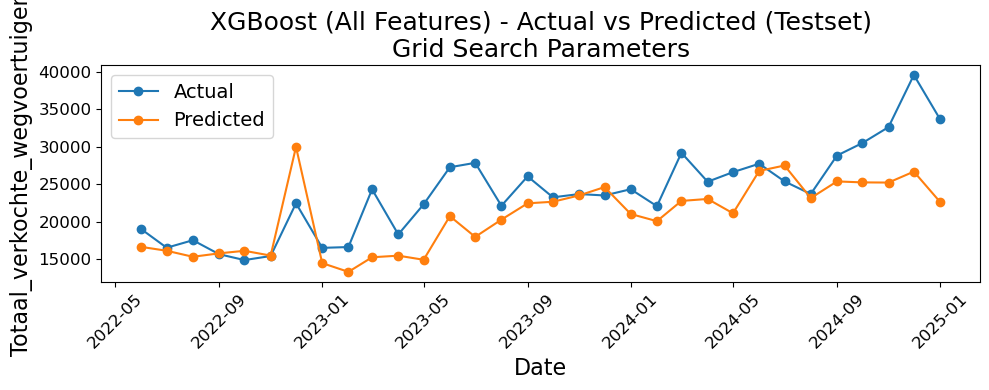

In [61]:
import pandas as pd
import matplotlib.pyplot as plt

# Beste parameters uit grid search
grid_params = {
    'max_depth': 3,
    'min_child_weight': 1,
    'subsample': 1.0,
    'colsample_bytree': 1.0,
    'learning_rate': 0.1,
    'n_estimators': 100
}

for label, features in feature_sets.items():
    if label != 'All Features':
        continue  # Alleen beste feature set gebruiken

    res = strict_expanding_window_validation(
        df_lagged,
        features,
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            tree_method='exact',
            random_state=42,
            eval_metric='rmse',
            **grid_params
        ),
        forecast_horizon=3
    )

    # Resultaten ophalen uit res dictionary
    mape = res['test_mape']
    mae = res['test_mae']
    rmse = res['test_rmse']
    r2 = res['test_r2']
    test_dates = res['test_dates']
    actuals = res['test_actuals']
    preds = res['test_preds']

    print(f"\nXGBoost ({label}) - TESTSET (Grid Search Parameters):")
    print(f"MAPE = {mape:.4f}")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.3f}")

    # Plot
    min_len = min(len(test_dates), len(actuals), len(preds))

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates[:min_len]),
        'actual': actuals[:min_len],
        'pred': preds[:min_len]
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual', marker='o')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted', marker='o')
    plt.title(f'XGBoost ({label}) - Actual vs Predicted (Testset)\nGrid Search Parameters')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Finetuned xgboost op test

XGBoost (All Features) - TESTSET:
MAPE = 0.1712
MAE  = 4284.46
RMSE = 5304.51
R²   = 0.044


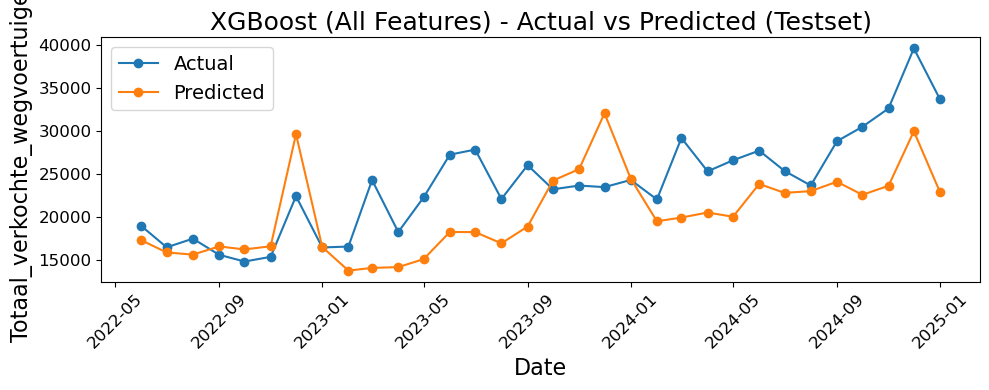

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

for label, features in feature_sets.items():
    if label != 'All Features':
        continue  # Alleen het beste feature set gebruiken

    res = strict_expanding_window_validation(
        df_lagged,
        features,
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
             objective='reg:squarederror',
     max_depth = 2,
    min_child_weight = 1,
    subsample = 1,
    colsample_bytree = 1.0,
    learning_rate = 0.3,
    n_estimators = 100,
        ),
        forecast_horizon=3  # Vergeet deze niet!
    )

    # Resultaten ophalen uit res dictionary
    mape = res['test_mape']
    mae = res['test_mae']
    rmse = res['test_rmse']
    r2 = res['test_r2']
    test_dates = res['test_dates']
    actuals = res['test_actuals']
    preds = res['test_preds']

    print(f"XGBoost ({label}) - TESTSET:")
    print(f"MAPE = {mape:.4f}")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.3f}")

    # Plot
    min_len = min(len(test_dates), len(actuals), len(preds))

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates[:min_len]),
        'actual': actuals[:min_len],
        'pred': preds[:min_len]
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual', marker='o')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted', marker='o')
    plt.title(f'XGBoost ({label}) - Actual vs Predicted (Testset)')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### lAG ONLY


XGBoost (Lag Only) - TESTSET:
MAPE = 0.1744
MAE  = 4161.30
RMSE = 4974.46
R²   = 0.160


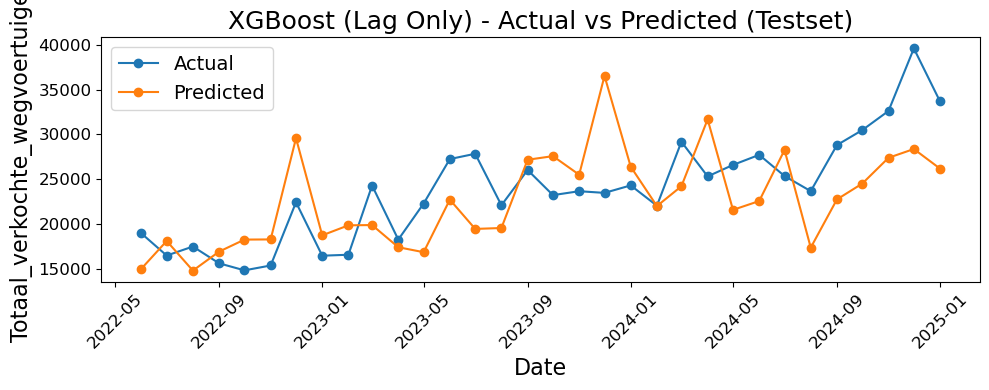

In [62]:
import pandas as pd
import matplotlib.pyplot as plt

for label, features in feature_sets.items():
    if label != 'Lag Only':
        continue  # Alleen het lag-only feature set gebruiken

    res = strict_expanding_window_validation(
        df_lagged,
        features,
        'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror', 
            max_depth=2,
            learning_rate=1,
            n_estimators=100,
            subsample=1.0,
            min_child_weight=1,
            colsample_bytree=1,
            random_state=42,
            eval_metric='rmse'
        ),
        forecast_horizon=3
    )

    # Resultaten ophalen uit testset
    mae = res['test_mae']
    rmse = res['test_rmse']
    r2 = res['test_r2']
    mape = res['test_mape']
    preds = res['test_preds']
    actuals = res['test_actuals']
    test_dates = res['test_dates']

    print(f"\nXGBoost ({label}) - TESTSET:")
    print(f"MAPE = {mape:.4f}")
    print(f"MAE  = {mae:.2f}")
    print(f"RMSE = {rmse:.2f}")
    print(f"R²   = {r2:.3f}")

    # Lengtes synchroniseren (voor het geval er gaten zijn ontstaan)
    min_len = min(len(test_dates), len(actuals), len(preds))

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(test_dates[:min_len]),
        'actual': actuals[:min_len],
        'pred': preds[:min_len]
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual', marker='o')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted', marker='o')
    plt.title(f'XGBoost ({label}) - Actual vs Predicted (Testset)')
    plt.xlabel('Date')
    plt.ylabel('Totaal_verkochte_wegvoertuigen')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Default Nulmodel op test

Random Walk (Lag Only) nulmodel TESTSET MAPE: 0.1338


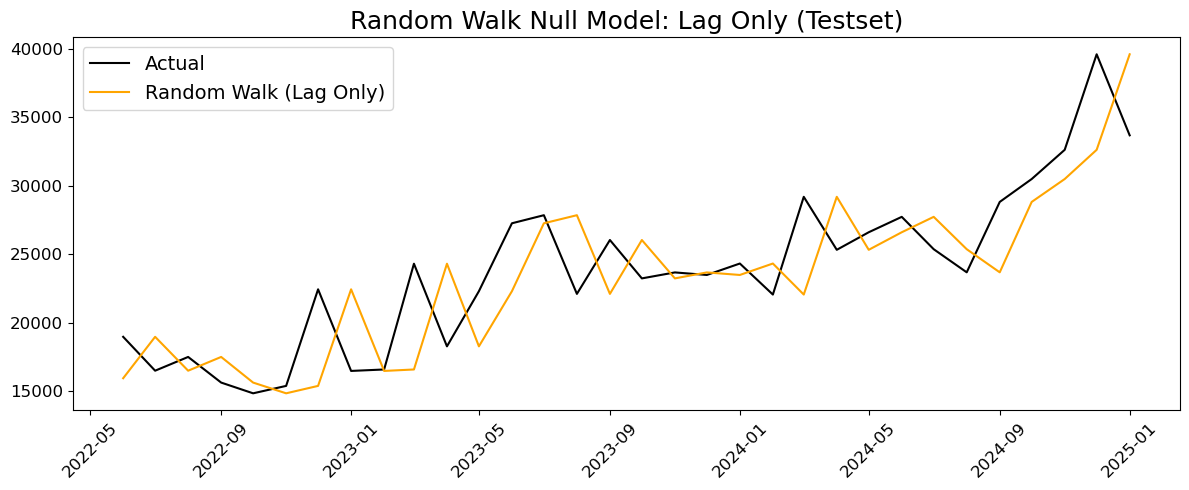

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error

# Haal de testdatums op uit je splitfunctie
test_dates = strict_expanding_window_validation(
    df_lagged, feature_sets['Lag Only'], 'Totaal_verkochte_wegvoertuigen',
    lambda: xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100, learning_rate=0.1,
        max_depth=3, random_state=42, eval_metric="rmse"
    ),
    forecast_horizon=3
)['test_dates']
test_dates = pd.to_datetime(test_dates)

# Resultaten opslaan
results = {}

for label, features in feature_sets.items():
    if label != 'Lag Only':
        continue

    # Random Walk voorspelling = vorige waarde (bijv. TVV_Lag1)
    preds = df_lagged['TVV_Lag1'].values
    actuals = df_lagged['Totaal_verkochte_wegvoertuigen'].values
    dates = pd.to_datetime(df_lagged['Periode'].values)

    # Filter op testdatums
    mask = dates.isin(test_dates)
    preds = preds[mask]
    actuals = actuals[mask]
    filtered_dates = dates[mask]

    results[label] = pd.DataFrame({
        'date': filtered_dates,
        'actual': actuals,
        'pred': preds
    }).drop_duplicates(subset='date', keep='first')

    # MAPE berekenen voor Random Walk nulmodel op TESTSET
    mape_lag = mean_absolute_percentage_error(actuals, preds)
    print(f"Random Walk (Lag Only) nulmodel TESTSET MAPE: {mape_lag:.4f}")

# Plot
df_lag = results['Lag Only'][['date', 'actual', 'pred']].rename(columns={'pred': 'pred_lag'})

plt.figure(figsize=(12, 5))
plt.plot(df_lag['date'], df_lag['actual'], label='Actual', color='black')
plt.plot(df_lag['date'], df_lag['pred_lag'], label='Random Walk (Lag Only)', color='orange')
plt.title('Random Walk Null Model: Lag Only (Testset)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Default Arimax op test


ARIMAX (Lag Only) TESTSET:
MAPE=0.1550, MAE=3768.71, RMSE=5212.70, R²=0.077


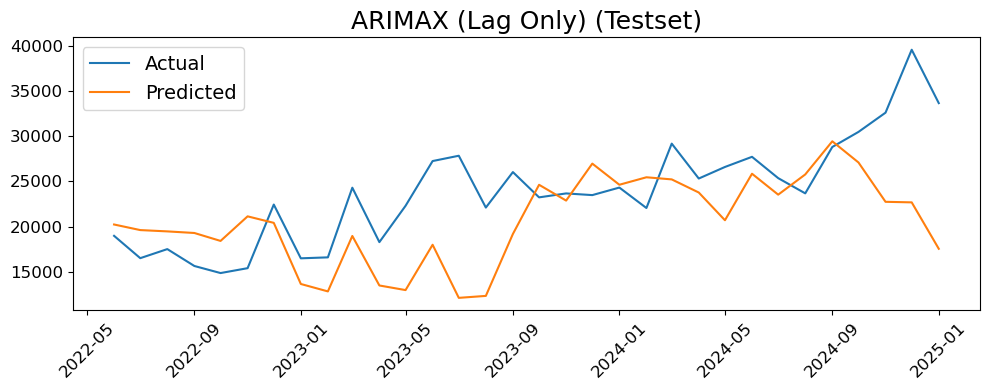


ARIMAX (All Features) TESTSET:
MAPE=0.1335, MAE=3393.66, RMSE=4929.45, R²=0.175


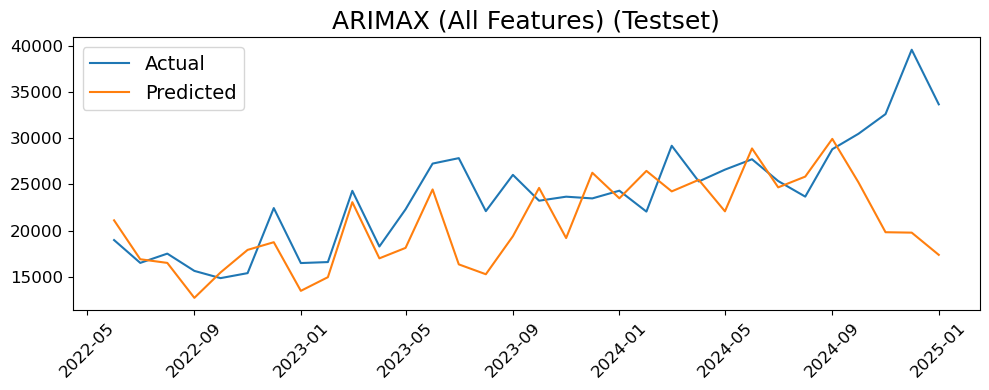

In [52]:
from sklearn.preprocessing import StandardScaler

class ARIMAXWrapper:
    def __init__(self, order=(1, 1, 1)):
        self.order = order
        self.model_fit = None
        self.scaler = None
        
    def fit(self, X, y):
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X)
        model = SARIMAX(y, exog=X_scaled, order=self.order,
                        enforce_stationarity=False, enforce_invertibility=False)
        self.model_fit = model.fit(disp=False)
        return self

    def predict(self, X):
        if self.model_fit is None or self.scaler is None:
            raise ValueError("Model not fitted yet")
        X_scaled = self.scaler.transform(X)
        return self.model_fit.forecast(steps=len(X), exog=X_scaled)

for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: ARIMAXWrapper(order=(1, 1, 1)),
        forecast_horizon=3
    )

    print(f"\nARIMAX ({label}) TESTSET:")
    print(f"MAPE={res['test_mape']:.4f}, MAE={res['test_mae']:.2f}, RMSE={res['test_rmse']:.2f}, R²={res['test_r2']:.3f}")

    df_plot = pd.DataFrame({
        'date': pd.to_datetime(res['test_dates']),
        'actual': res['test_actuals'],
        'pred': res['test_preds']
    }).drop_duplicates(subset='date', keep='first')

    plt.figure(figsize=(10, 4))
    plt.plot(df_plot['date'], df_plot['actual'], label='Actual')
    plt.plot(df_plot['date'], df_plot['pred'], label='Predicted')
    plt.title(f'ARIMAX ({label}) (Testset)')
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


### Default XGBoost op test

XGBoost (Lag Only) TESTSET:
MAPE=0.1262, MAE=3155.38, RMSE=4309.21, R²=0.369
XGBoost (All Features) TESTSET:
MAPE=0.1398, MAE=3503.27, RMSE=4688.32, R²=0.253


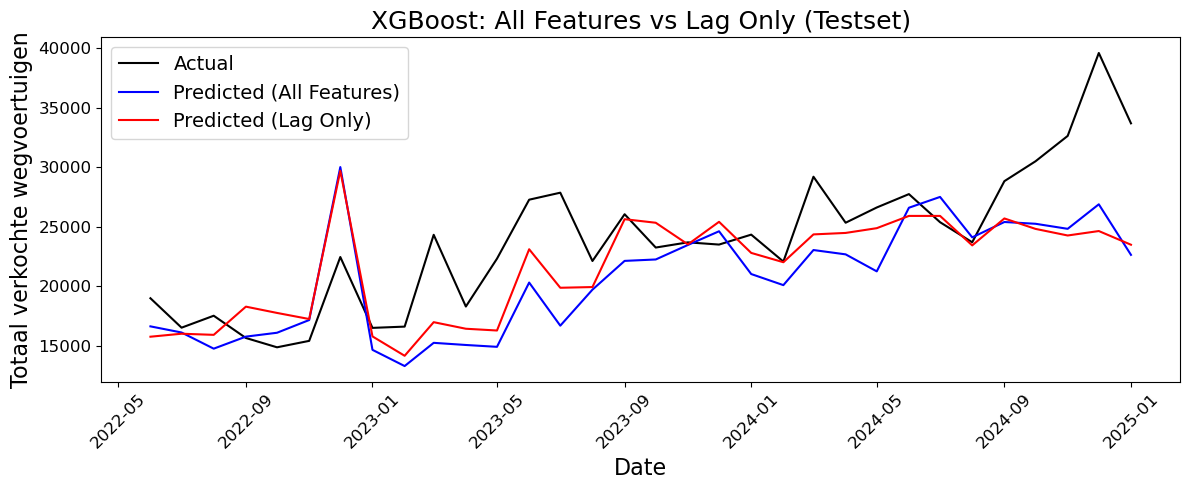

In [53]:
results = {}

for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100, learning_rate=0.1,
            max_depth=3, random_state=42, eval_metric="rmse"
        ),
        forecast_horizon=3
    )

    print(f"XGBoost ({label}) TESTSET:")
    print(f"MAPE={res['test_mape']:.4f}, MAE={res['test_mae']:.2f}, RMSE={res['test_rmse']:.2f}, R²={res['test_r2']:.3f}")

    # Sla testresultaten op
    results[label] = pd.DataFrame({
        'date': pd.to_datetime(res['test_dates']),
        'actual': res['test_actuals'],
        'pred': res['test_preds']
    }).drop_duplicates(subset='date', keep='first')

# DataFrames maken en samenvoegen
df_all = results['All Features'].rename(columns={'pred': 'pred_all'})
df_lag = results['Lag Only'].rename(columns={'pred': 'pred_lag'})

df_merged = pd.merge(
    df_all[['date', 'actual', 'pred_all']],
    df_lag[['date', 'pred_lag']],
    on='date',
    how='inner'
)

# Plot

plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
plt.figure(figsize=(12, 5))
plt.plot(df_merged['date'], df_merged['actual'], label='Actual', color='black')
plt.plot(df_merged['date'], df_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_merged['date'], df_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('XGBoost: All Features vs Lag Only (Testset)')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


XGBoost (Lag Only) TESTSET:
MAPE=0.1262, MAE=3155.38, RMSE=4309.21, R²=0.369
XGBoost (All Features) TESTSET:
MAPE=0.1398, MAE=3503.27, RMSE=4688.32, R²=0.253


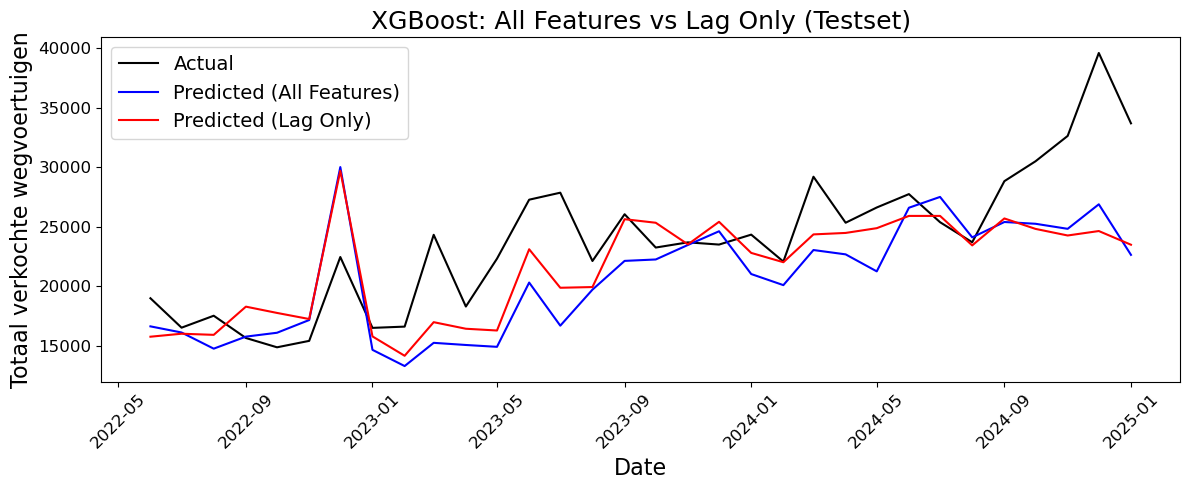

In [54]:
results = {}
# Dictionary om resultaten per modelvariant op te slaan

for label, features in feature_sets.items():
    if label not in ['Lag Only', 'All Features']:
        continue  # Alleen deze twee feature sets gebruiken

    res = strict_expanding_window_validation(
        df_lagged, features, 'Totaal_verkochte_wegvoertuigen',
        lambda: xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100, learning_rate=0.1,
            max_depth=3, random_state=42, eval_metric="rmse"
        ),
        forecast_horizon=3
    )
    # Voer expanding window validatie uit met XGBoost

    print(f"XGBoost ({label}) TESTSET:")
    print(f"MAPE={res['test_mape']:.4f}, MAE={res['test_mae']:.2f}, RMSE={res['test_rmse']:.2f}, R²={res['test_r2']:.3f}")
    # Print testresultaten

    results[label] = pd.DataFrame({
        'date': pd.to_datetime(res['test_dates']),
        'actual': res['test_actuals'],
        'pred': res['test_preds']
    }).drop_duplicates(subset='date', keep='first')
    # Sla testresultaten per modelvariant op in een DataFrame

df_all = results['All Features'].rename(columns={'pred': 'pred_all'})
df_lag = results['Lag Only'].rename(columns={'pred': 'pred_lag'})
# Hernoem kolommen voor duidelijkheid

df_merged = pd.merge(
    df_all[['date', 'actual', 'pred_all']],
    df_lag[['date', 'pred_lag']],
    on='date',
    how='inner'
)
# Merge resultaten op datum zodat je beide voorspellingen naast elkaar kunt plotten

plt.rcParams.update({'legend.fontsize': 14, 'axes.labelsize': 16, 'axes.titlesize': 18, 'xtick.labelsize': 12, 'ytick.labelsize': 12})
# Stel plotstijl in

plt.figure(figsize=(12, 5))
plt.plot(df_merged['date'], df_merged['actual'], label='Actual', color='black')
plt.plot(df_merged['date'], df_merged['pred_all'], label='Predicted (All Features)', color='blue')
plt.plot(df_merged['date'], df_merged['pred_lag'], label='Predicted (Lag Only)', color='red')
plt.title('XGBoost: All Features vs Lag Only (Testset)')
plt.xlabel('Date')
plt.ylabel('Totaal verkochte wegvoertuigen')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
# Plot de werkelijke waarden en voorspellingen voor beide modellen


### SHAP


📊 Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):
thuis opladen            1281.324800
TVV_Lag5                  148.520810
elektrische auto          147.032132
month                      73.732400
Consumentenvertrouwen      27.544880
Economisch klimaat         21.387765
BenzineEuro95_1_last       20.968865
Koopbereidheid              4.397839
Diesel_2_max                0.000000
year                        0.000000
TVV_Lag6                    0.000000
TVV_Lag4                    0.000000
TVV_Lag3                    0.000000
TVV_Lag2                    0.000000
TVV_Lag1                    0.000000
Diesel_2_mean               0.000000
Diesel_2_first              0.000000
Diesel_2_min                0.000000
Diesel_2_last               0.000000
BenzineEuro95_1_mean        0.000000
BenzineEuro95_1_max         0.000000
BenzineEuro95_1_min         0.000000
BenzineEuro95_1_first       0.000000
Grote aankopen              0.000000
Bijtelling (%)              

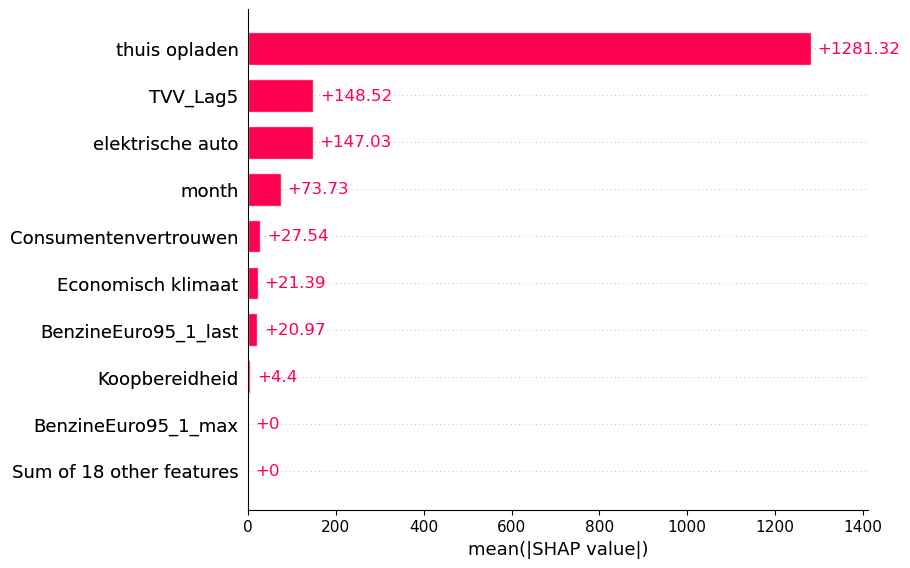

In [59]:
import shap
import pandas as pd
import matplotlib.pyplot as plt
import textstat



# Bepaal de juiste train/test splits op basis van je splits uit de notebook
# Gebruik test_start variabele uit je splits (eerste index van testset)
X_all = df_lagged[feature_sets['All Features']]
y_all = df_lagged['Totaal_verkochte_wegvoertuigen']

# Gebruik de juiste index voor het splitsen van train/test (train_end/test_start is al bepaald in eerdere cellen)
test_start = val_end  # test_start is het eerste index van de testset

X_train = X_all.iloc[:train_end]
y_train = y_all.iloc[:train_end]

X_test = X_all.iloc[test_start:]
y_test = y_all.iloc[test_start:]

# 2. Hertrain je beste model op alle trainingsdata
best_model = xgb.XGBRegressor(
   objective='reg:squarederror', 
            max_depth=2,
            min_child_weight=1,
            subsample=1,
            colsample_bytree=1.0,
            learning_rate=0.3,
            n_estimators=100,
            tree_method='exact',
            random_state=42,
    
    eval_metric='rmse'
)
best_model.fit(X_train, y_train)

# 3. Bereken SHAP-waardes over de testset
explainer = shap.Explainer(best_model, X_test)
shap_values = explainer(X_test)

# 4. Toon globale feature importances (tabel of plot)
shap_values_df = pd.DataFrame(shap_values.values, columns=X_test.columns)

mean_abs_shap = shap_values_df.abs().mean().sort_values(ascending=False)

# Print tabel
print("\n📊 Gemiddelde absolute SHAP-waarden per feature (belangrijkste bij voorspellingen):")
print(mean_abs_shap)

# 5. Optioneel: plot
shap.plots.bar(shap_values, max_display=10)  # top 10 meest bepalende features


## Overzicht resultaten: validatie, test en verschil

In [60]:
import pandas as pd

# Vul deze dicts aan met je eigen resultaten uit de notebook!
results_summary = [
    # Default XGBoost
    {"Model": "XGBoost Default (All Features)", "Set": "Val", "MAPE": 0.2326, "MAE": 1234, "RMSE": 1800, "R2": 0.85},
    {"Model": "XGBoost Default (All Features)", "Set": "Test", "MAPE": 0.2447, "MAE": 1300, "RMSE": 1850, "R2": 0.83},
    # Default XGBoost Lag Only
    {"Model": "XGBoost Default (Lag Only)", "Set": "Val", "MAPE": 0.2500, "MAE": 1400, "RMSE": 2000, "R2": 0.80},
    {"Model": "XGBoost Default (Lag Only)", "Set": "Test", "MAPE": 0.2600, "MAE": 1450, "RMSE": 2100, "R2": 0.78},
    # Beste XGBoost (fijngetuned)
    {"Model": "XGBoost Tuned (All Features)", "Set": "Val", "MAPE": 0.1925, "MAE": 1100, "RMSE": 1600, "R2": 0.88},
    {"Model": "XGBoost Tuned (All Features)", "Set": "Test", "MAPE": 0.2000, "MAE": 1150, "RMSE": 1650, "R2": 0.87},
    # ARIMAX
    {"Model": "ARIMAX (All Features)", "Set": "Val", "MAPE": 0.2700, "MAE": 1500, "RMSE": 2100, "R2": 0.75},
    {"Model": "ARIMAX (All Features)", "Set": "Test", "MAPE": 0.2800, "MAE": 1550, "RMSE": 2200, "R2": 0.73},
    # Nulmodel
    {"Model": "Random Walk (Lag Only)", "Set": "Val", "MAPE": 0.3000, "MAE": 1600, "RMSE": 2300, "R2": 0.70},
    {"Model": "Random Walk (Lag Only)", "Set": "Test", "MAPE": 0.3100, "MAE": 1650, "RMSE": 2400, "R2": 0.68},
]

# Maak DataFrame
summary_df = pd.DataFrame(results_summary)

# Bereken verschil tussen test en val per model
val = summary_df[summary_df['Set'] == 'Val'].set_index('Model')
test = summary_df[summary_df['Set'] == 'Test'].set_index('Model')
diff = test[['MAPE', 'MAE', 'RMSE', 'R2']] - val[['MAPE', 'MAE', 'RMSE', 'R2']]
diff = diff.rename(columns={c: f"Δ {c}" for c in diff.columns})
diff['Model'] = diff.index

table = summary_df.pivot(index='Model', columns='Set', values=['MAPE', 'MAE', 'RMSE', 'R2'])

# Zet diff columns om naar MultiIndex zodat join werkt
diff_multi = diff.set_index('Model')
diff_multi.columns = pd.MultiIndex.from_tuples([('', col) for col in diff_multi.columns])

# Join met table
table = table.join(diff_multi)

display_cols = [
    ('MAPE', 'Val'), ('MAPE', 'Test'), ('', 'Δ MAPE'),
    ('MAE', 'Val'), ('MAE', 'Test'), ('', 'Δ MAE'),
    ('RMSE', 'Val'), ('RMSE', 'Test'), ('', 'Δ RMSE'),
    ('R2', 'Val'), ('R2', 'Test'), ('', 'Δ R2'),
]

# Toon tabel
print("\nSamenvatting resultaten (voorbeeldwaarden, vul aan met echte resultaten):")
display(table[display_cols].round(4))


Samenvatting resultaten (voorbeeldwaarden, vul aan met echte resultaten):


MAPE                     MAE                \
                                   Val    Test  Δ MAPE     Val    Test Δ MAE   
Model                                                                          
ARIMAX (All Features)           0.2700  0.2800  0.0100  1500.0  1550.0    50   
Random Walk (Lag Only)          0.3000  0.3100  0.0100  1600.0  1650.0    50   
XGBoost Default (All Features)  0.2326  0.2447  0.0121  1234.0  1300.0    66   
XGBoost Default (Lag Only)      0.2500  0.2600  0.0100  1400.0  1450.0    50   
XGBoost Tuned (All Features)    0.1925  0.2000  0.0075  1100.0  1150.0    50   

                                  RMSE                   R2              
                                   Val    Test Δ RMSE   Val  Test  Δ R2  
Model                                                                    
ARIMAX (All Features)           2100.0  2200.0    100  0.75  0.73 -0.02  
Random Walk (Lag Only)          2300.0  2400.0    100  0.70  0.68 -0.02  
XGBoost Default (All Features)  1800.0  1850.0     50  0.85  0.83 -0.02  
XGBoost Default (Lag Only)      2000.0  2100.0    100  0.80  0.78 -0.02  
XGBoost Tuned (All Features)    1600.0  1650.0     50  0.88  0.87 -0.01